In [64]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import igrins_mod as ig
import glob
import os

import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column, join

from astropy.modeling import models, fitting

from scipy.integrate import trapz
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

# Things that should only have to be defined once, here at the top
---

In [65]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Use Normalized (single) Gaussian Distribution
def gaussian_func(x,ampl,center,std,b):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x - center)/std)**2)) + b

In [66]:
# Reduced data in txt files
# Desktop path
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged"

# Laptop Path
# data_path = "C:/Users/Savio/Documents/GitHub/IGRINS-Spectra/IGRINS_Merged/"
# File path for figures to live in
# Desktop path
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Laptop Path
# fig_path = "C:/Users/Savio/Documents/GitHub/IGRINS-Spectra/IGRINS_figs/standards_spectra/"


# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"/merged_standards/m*.fits")

yso_line_dict = {
    "HI 4-3 Paa": 1.8756,
    "HI 6-4 Brb": 2.6259,
    "HI 7-4 Brg": 2.1661,
    "HI 8-4 Brd": 1.9451,
    "HI 9-4 Bre": 1.8181,
    "HI 10-4 Br6": 1.7367,
    "HI 11-5": 2.8729,
    "HI 10-5": 3.0392,
    "HeI 3D-3": 1.7007,
    "HeI 1P-1": 2.0567,
    "HeI 3S-3": 2.1126,
    "HeI 19-8": 1.77244,
    "HeI 18-8": 1.81716,
    "HeI 6-5": 1.86418,
    "HeI 17-8": 1.87300,
    "HeI 8-6": 1.87484,
    "HeI 11-7": 1.87625,
    "HeI 16.8": 1.94429,
    "HeI 15-8": 2.03788,
    "HeI 14-8": 2.16523,
    "HeI 10-7": 2.18911,
    "HeI 13-8": 2.34703,
    "HeI 19-9": 2.37945,
    "HeI 18-9": 2.46074,
    "HeI 17-9": 2.56426,
    "HeI 12-8": 2.62479,
    "HeI 16-9": 2.69979,
    "HeI 9-7": 2.82600,
    "HeI 15-9": 2.88368,
    "HeI 7-6": 3.09169,
    "HeI 11-8": 3.09551,
    "HeI 14-9": 3.14574,
    "HeI 19-1": 3.15144,
    "H2 v=1-0 S(0)": 2.223,
    "H2 v=1-0 S(1)": 2.121,
    "H2 v=1-0 S(2)": 2.033,
    "H2 v=1-0 S(3)": 1.957,
    "H2 v=1-0 S(4)": 1.892,
    "H2 v=1-0 S(5)": 1.835,
    "H2 v=1-0 S(6)": 1.788,
    "H2 v=1-0 S(7)": 1.748,
    "H2 v=1-0 S(8)": 1.714,
    "H2 v=1-0 Q(1)": 2.406,
    "H2 v=1-0 Q(2)": 2.413,
    "H2 v=1-0 Q(3)": 2.423,
    "H2 v=1-0 Q(4)": 2.437,
    "H2 v=1-0 Q(5)": 2.454,
    "H2 v=1-0 Q(6)": 2.475,
    "H2 v=1-0 Q(7)": 2.5,
    "H2 v=1-0 O(2)": 2.626,
    "H2 v=1-0 O(3)": 2.802,
    "H2 v=1-0 O(4)": 3.003,
    "H2 v=2-1 S(0)": 2.355,
    "H2 v=2-1 S(1)": 2.247,
    "H2 v=2-1 S(2)": 2.154,
    "H2 v=2-1 S(3)": 2.073,
    "H2 v=2-1 S(4)": 2.004,
    "H2 v=2-1 S(5)": 1.944,
    "H2 v=2-1 O(2)": 2.786,
    "H2 v=2-1 O(3)": 2.974,
    "H2 v=2-1 O(4)": 3.189,
    "H2 v=3-2 S(0)": 2.501,
    "H2 v=3-2 S(1)": 2.386,
    "H2 v=3-2 S(2)": 2.287,
    "H2 v=3-2 S(3)": 2.201,
    "H2 v=3-2 S(4)": 2.128,
    "H2 v=3-2 S(5)": 2.065,
    "H2 v=3-2 S(6)": 2.013,
    "H2 v=3-2 S(7)": 1.969,
    "H2 v=3-2 O(2)": 2.962,
    "H2 v=3-2 O(3)": 3.163,
    "H2 v=4-3 S(3)": 2.344,
    "H2 v=4-3 S(4)": 2.266,
    "H2 v=4-3 S(5)": 2.201,
    "H2 v=5-4 S(5)": 2.355,
    "H2 v=5-4 S(7)": 2.251,
    "CO 2-0": 2.2935,
    "CO 3-1": 2.3227,
    "CO 4-2": 2.3525,
    "CO 5-3": 2.3829,
    "CO 6-4": 2.4142,
    "CO 7-5": 2.4461,
    "CO 8-6": 2.4787,
    "CO 9-5": 2.5122,
    "[Fe II]": 1.918062,
    "[Fe II]": 1.918547,
    "[Ti I]": 1.931226,
    "[Fe III]": 2.2184,
    "[Mn II]": 2.12647,
    "[Mn II]": 2.27944,
    "HI 12-5": 2.75829,
    "HI 13-5": 2.67515,
    "HI 14-5": 2.61267,
    "HI 15-5": 2.56435,
    "HI 16-5": 2.52611,
    "HI 17-5": 2.49527,
    "HI 18-5": 2.47001,
    "HI 19-5": 2.44902,
    "HI 20-5": 2.43138,
    "HI 21-5": 2.4164,
    "HI 22-5": 2.40357,
    "HI 23-5": 2.39249,
    "HI 24-5": 2.38284,
    "HI 25-5": 2.3744,
    "HI 26-5": 2.36696,
    "HI 27-5": 2.36037,
    "HI 28-5": 2.3545,
    "HI 29-5": 2.34926,
    "HI 30-5": 2.34455,
    "[Mn III]": 2.4331,
    "[Fe II]??": 2.467565,
    "[Cr III][V II]": 2.62623,
    "[Co IV]": 2.5932,
    "[Fe I]": 2.5059805,
    "[Fe II]": 2.599329,
    "[V I]": 2.59823,
    "[Cu IV]": 2.5983,
    "[Co II][Ni VI]": 2.5308,
    "Ne II ??": 2.55066,
    "[Sc I]": 2.96879,
    "[Fe I]": 1.8485546,
    "[Mn III]": 1.91,
    "[V II]": 1.76199,
    "He I 2.05": 2.05869,
    "[Ti I]": 2.008516,
    "[Mn II]": 2.00229,
    "[Ni IV]": 2.7181,
    "He I 2.75": 2.75704,
    "[Fe IV]": 2.8063,
    "He I 1.86": 1.86904,
    "Fe I 2.55": 2.5580374,
    "Fe I 2.56": 2.5693161,
    "Fe I (C I?)": 2.58404,
    "Fe I 2.60": 2.6037869,
    "[Fe II]": 2.28573
  }

# Strings of the lines
ysolines_str = list(yso_line_dict.keys())

# Wavelength values for each line
ysolines_wav = np.array(list(yso_line_dict.values()))
ysolines_wav = ysolines_wav[(ysolines_wav > 1.9) & (ysolines_wav < 2.5)]

# NIR Lines in micron
nir_dict = {
    "Fe-2.084"  :   2.084088,
    "Si-2.092"	:   2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.224,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573":	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297
}
# The CO Overtones will be an interesting challenge I'm sure
    # "CO(2-0)-2.29353" :	2.29353,
    # "CO(2-0)-2.32265"	:	2.32265,
    # "CO(2-0)-2.34327" :	2.34327,
    # "CO(2-0)-2.34531" :	2.34531,
    # "CO(2-0)-2.3495" 	:	2.3495,
    # "CO(2-0)-2.35167"	:	2.35167,
    # "CO(2-0)-2.35246" :	2.35246,
    # "CO(2-0)-2.38295" :	2.38295,
    # }

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = np.array(list(nir_dict.values()))

# Just a list of the elemental shorthand symbols
labels = [string.split('-')[0] for string in lines_str]

In [67]:
ysolines_wav[ysolines_wav > 1.9]

array([2.1661  , 1.9451  , 2.0567  , 2.1126  , 1.94429 , 2.03788 ,
       2.16523 , 2.18911 , 2.34703 , 2.37945 , 2.46074 , 2.223   ,
       2.121   , 2.033   , 1.957   , 2.406   , 2.413   , 2.423   ,
       2.437   , 2.454   , 2.475   , 2.355   , 2.247   , 2.154   ,
       2.073   , 2.004   , 1.944   , 2.386   , 2.287   , 2.201   ,
       2.128   , 2.065   , 2.013   , 1.969   , 2.344   , 2.266   ,
       2.201   , 2.355   , 2.251   , 2.2935  , 2.3227  , 2.3525  ,
       2.3829  , 2.4142  , 2.4461  , 2.4787  , 2.28573 , 2.008516,
       2.2184  , 2.00229 , 2.49527 , 2.47001 , 2.44902 , 2.43138 ,
       2.4164  , 2.40357 , 2.39249 , 2.38284 , 2.3744  , 2.36696 ,
       2.36037 , 2.3545  , 2.34926 , 2.34455 , 1.91    , 2.467565,
       2.05869 ])

In [68]:
# get data from fits file
data = fits.getdata(merged_standard_files[0])
# Data Columns
wavelen = data[0] # micron
flux = data[1] # counts
snr = data[2] # SNR per resolution element

# Clean data a bit?
snr_min = 50 # Minimum SNR
snr_max = 1e4
snr_cut = (snr > snr_min) & (snr < snr_max) # Bitwise masking

flux_min = 0
flux_cut = flux > 0

wavelen = wavelen[snr_cut & flux_cut]
flux = flux[snr_cut & flux_cut]
snr = snr[snr_cut & flux_cut]

# Normalize the flux by the median (?)
norm_flux = flux/np.median(flux)

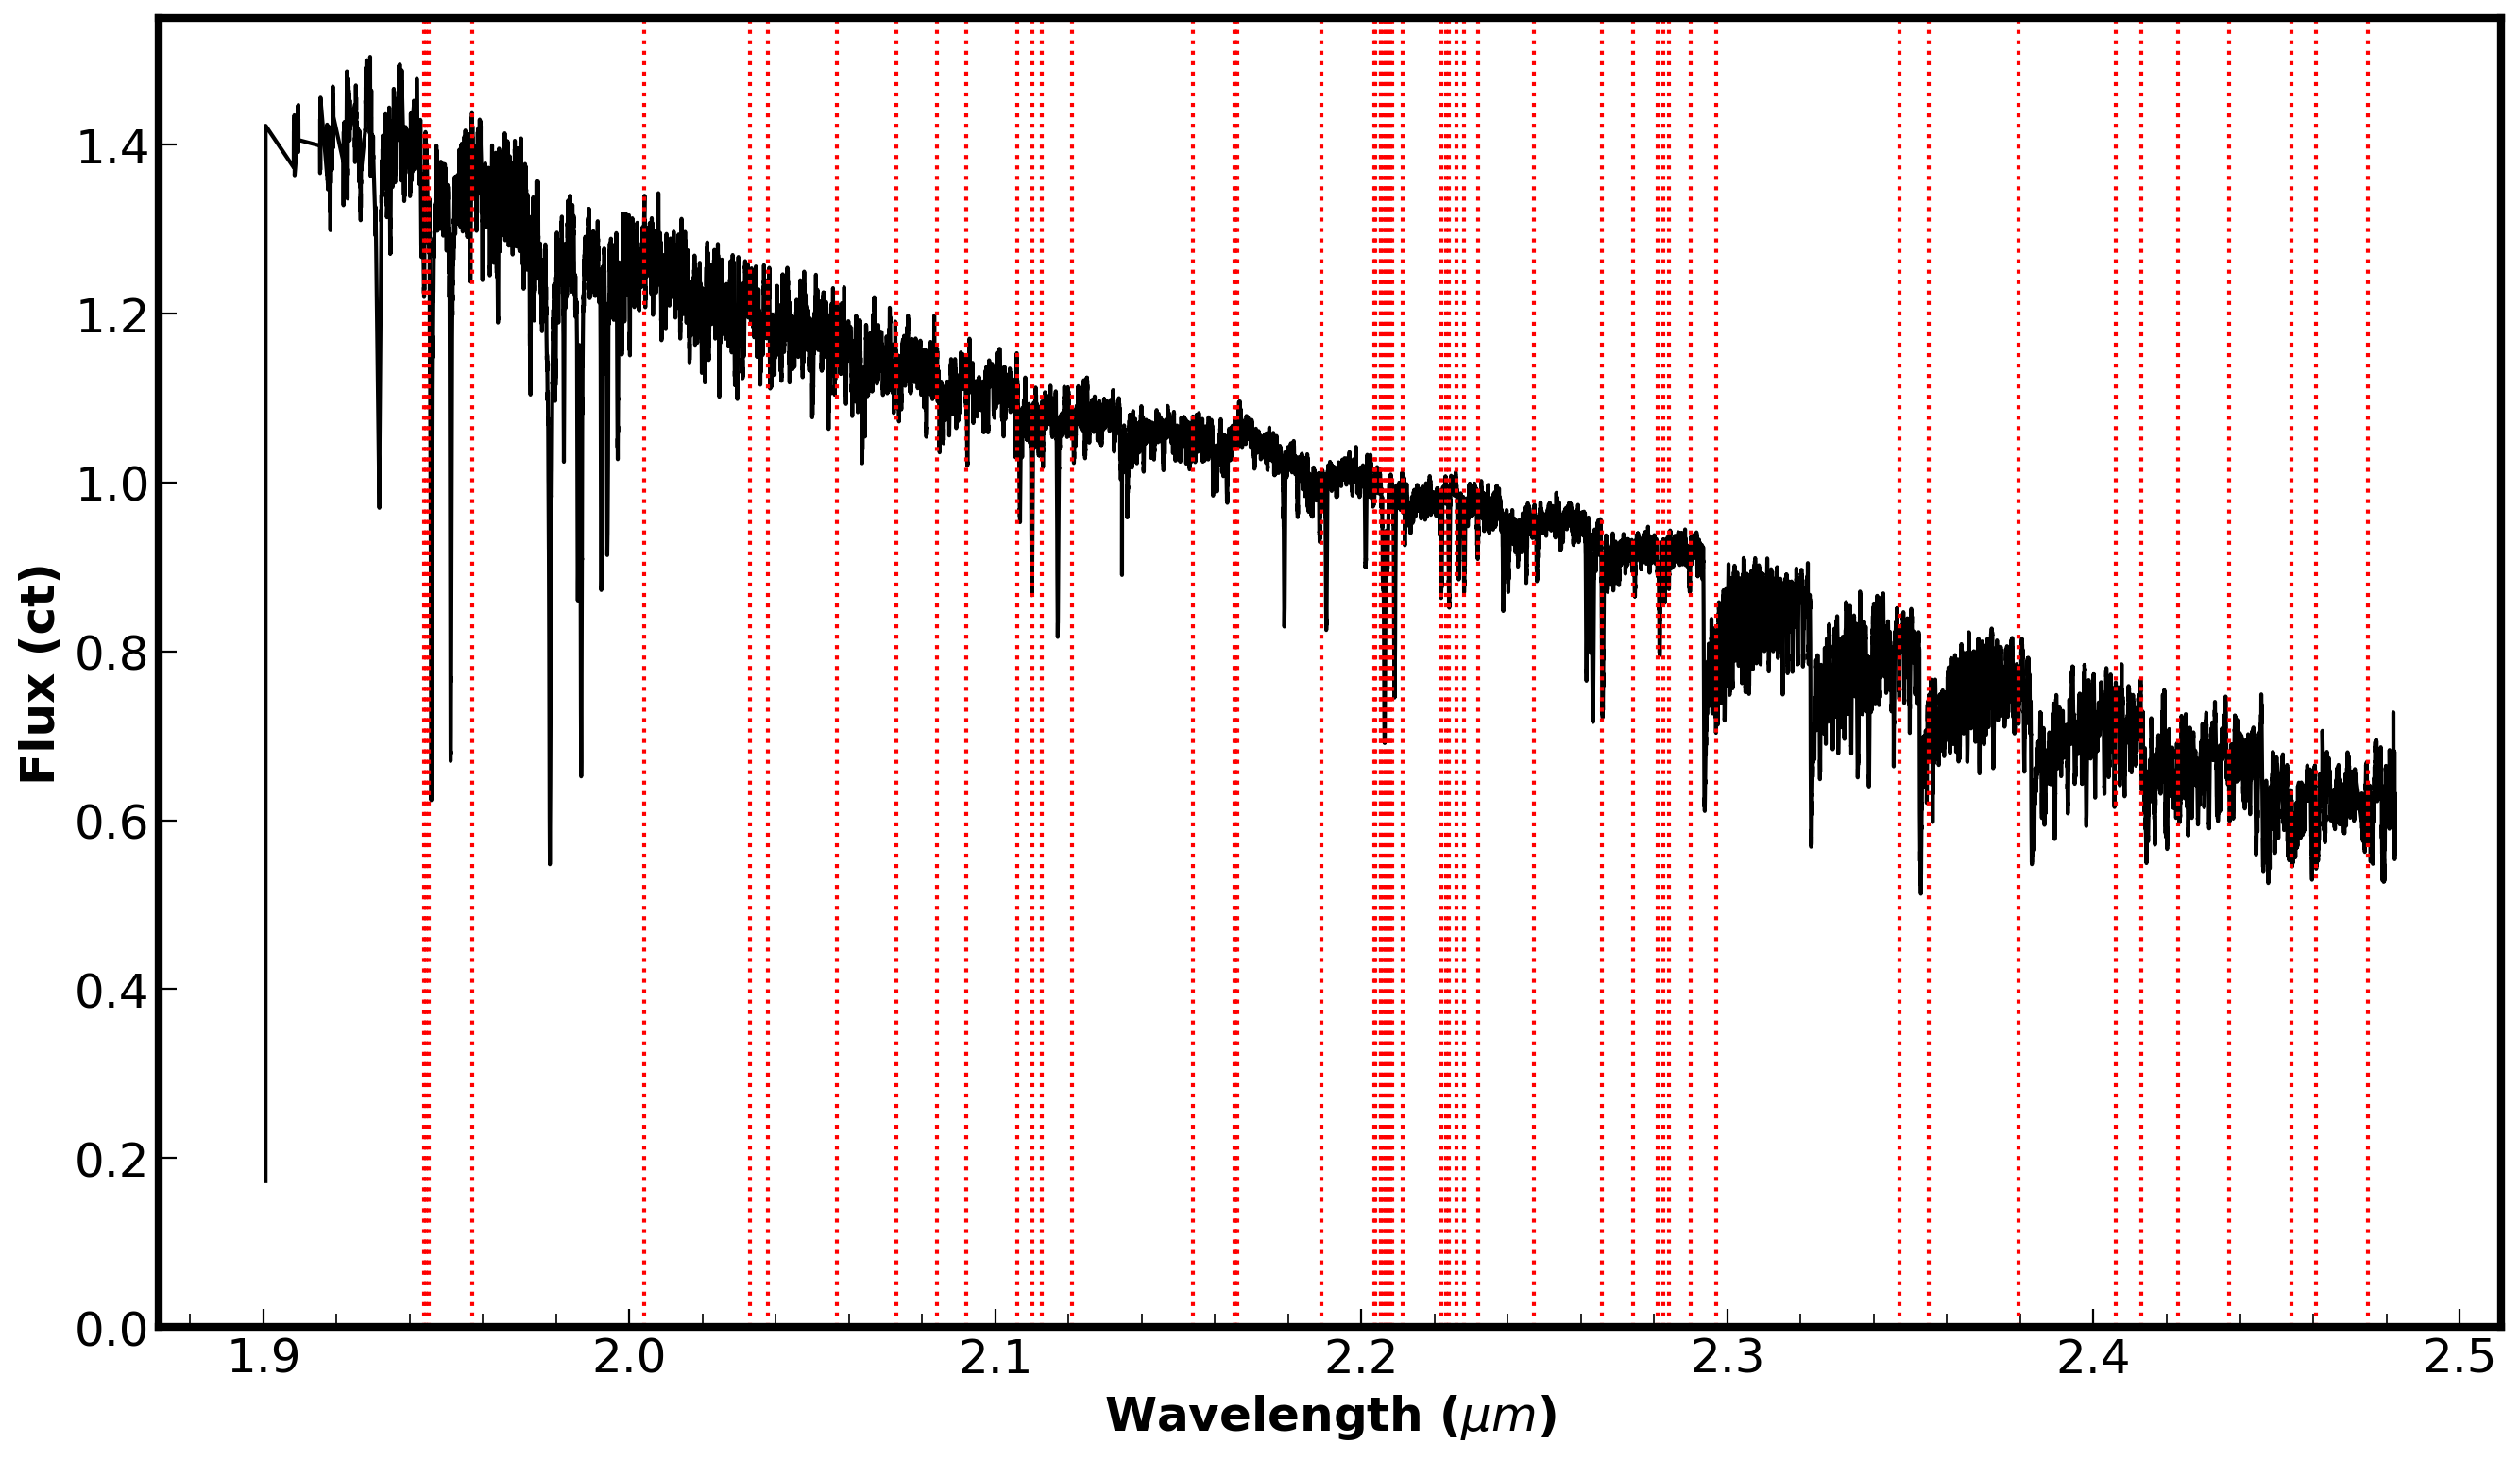

In [69]:
plt.figure(figsize=(16,9))

plt.plot(wavelen,norm_flux,'-',color='black')

for i in range(len(lines_wav)):
    plt.axvline(lines_wav[i],ls=':',c='red')
    plt.axvline(ysolines_wav[i],ls=':',c='red')
    # plt.xlim(lines_wav[i]-10*spec_res,lines_wav[i+1]+10*spec_res)

# plt.xlim(1.9,2.0)
plt.ylim(0,1.55)

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct")) 

plt.show()

# Gaussian Fitting
---

In [70]:
# Central wavelength of line (micron)
line_center = lines_wav[16]

wave_left = line_center - (75*spec_res)
wave_right = line_center + (75*spec_res)

# Spectral feature max and min wavelength indices
wavemin_idx = np.abs(wavelen - wave_left).argmin()
wavemax_idx = np.abs(wavelen - wave_right).argmin()

# Choose spectral regions on either side of spectral feature to define a continuum
contlo_1 = wave_left-(20*spec_res)
contlo_2 = wave_left

conthi_1 = wave_right
conthi_2 = wave_right+(20*spec_res)

# Find the indices for the continuum regions on either side of the spectral feature
contlo_min = np.abs(wavelen - contlo_1).argmin()
contlo_max = np.abs(wavelen - contlo_2).argmin()

conthi_min = np.abs(wavelen - conthi_1).argmin()
conthi_max = np.abs(wavelen - conthi_2).argmin()
#################################################
# estimate continuum using mean of points in selected range

# wavelength range of where I'm estimating continuum
contlo_wave = wavelen[contlo_min:contlo_max]
conthi_wave = wavelen[conthi_min:conthi_max]

# fluxe range of where I'm estimating continuum
contlo_flux = flux[contlo_min:contlo_max]
conthi_flux = flux[conthi_min:conthi_max]

contwave_array = np.concatenate((contlo_wave, conthi_wave))
contflux_array = np.concatenate((contlo_flux, conthi_flux))

mean_cont = np.sum(contflux_array)/len(contflux_array)

# estimate continuum using 1d polyfit to points in selected range
cont_fit = np.polyfit(contwave_array, contflux_array, 1)
fitval = np.poly1d(cont_fit)
continuum = fitval(wavelen)

cont_sub = flux-continuum # the polyfit continuum-subtracted flux
cont_norm = flux/continuum # polyfit continuum normalized flux

meancont_sub = flux-mean_cont # the mean continuum-subtracted flux
meancont_norm = flux/mean_cont # mean continuum normalized flux

In [71]:
# initial guesses, need 4 inputs: Amplitude, center, std_dev, b (y offset)
init_params = 0.25, line_center, 1., 0.

popt, pcov = curve_fit(f=gaussian_func,
                        xdata=wavelen[contlo_min:conthi_max],
                        ydata=cont_norm[contlo_min:conthi_max],
                        maxfev=100000)

best_model = gaussian_func(wavelen,*popt)

print("Best Fit Parameters:", popt)

Best Fit Parameters: [-5.59378902e-05  2.22395778e+00  1.56470011e-04  1.00024355e+00]


In [72]:
print(f'{popt[0]:10f}')

 -0.000056


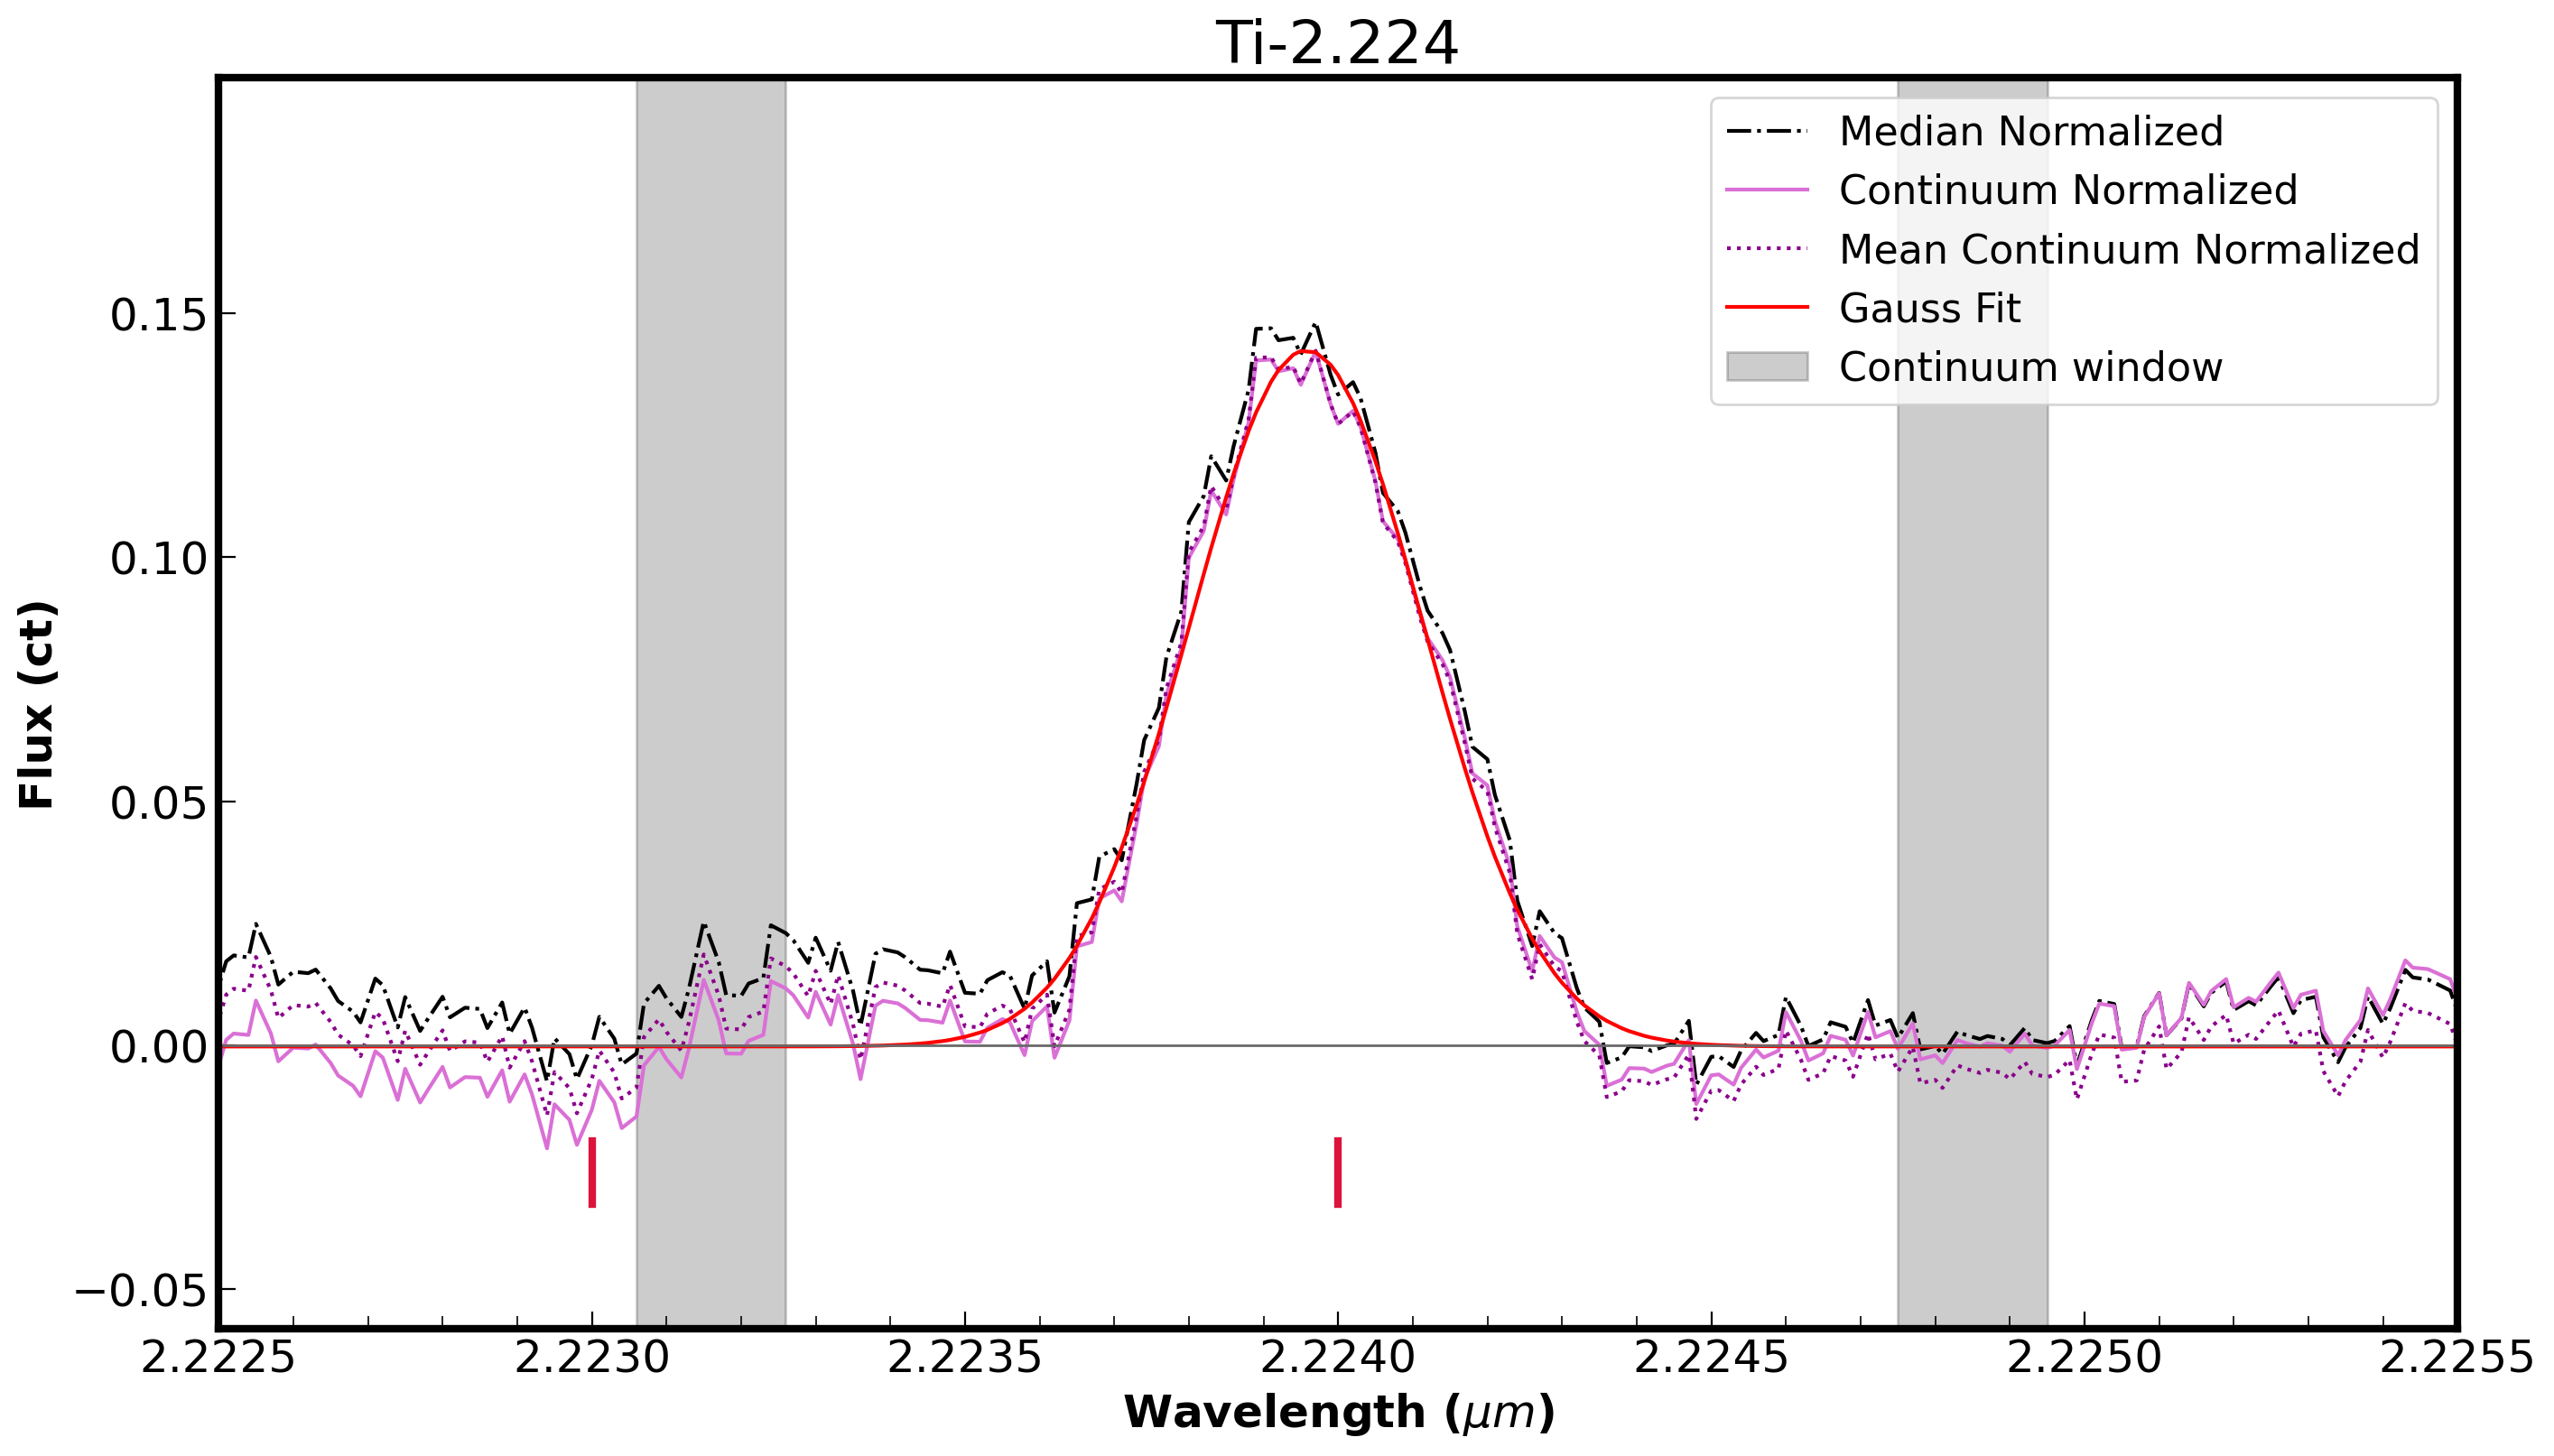

In [79]:
fig = plt.subplots(figsize=(16,9))

plt.plot(wavelen,1-norm_flux,ls='-.', color='black', label='Median Normalized')
plt.plot(wavelen,1-cont_norm, color='orchid',label='Continuum Normalized')
plt.plot(wavelen,1-meancont_norm,ls=':', color='darkmagenta',label='Mean Continuum Normalized')

plt.plot(wavelen,1-best_model,ls='-', color='red',label='Gauss Fit')

# Continuum Estimation region
plt.axvspan(wavelen[contlo_min],wavelen[contlo_max], color='black', alpha=0.2,label='Continuum window')
plt.axvspan(wavelen[conthi_min],wavelen[conthi_max], color='black', alpha=0.2)


for i in range(len(lines_wav)):
    plt.axvline(lines_wav[i],.1,.15,ls='-',lw=3,c='crimson')
    plt.axvline(ysolines_wav[i],.1,.15,ls='-',lw=3,c='crimson')
    
plt.axhline(1,color='orange',lw=1,ls='-')
plt.axhline(0,color='dimgray',lw=1,ls='-')

plt.xlim(line_center-150*spec_res,line_center+150*spec_res)
# 0.05
plt.ylim((1-norm_flux[contlo_min:conthi_max]).min()-.05,
         (1-norm_flux[contlo_min:conthi_max]).max()+.05)

plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
plt.ylabel('Flux ({})'.format("ct")) 

plt.title(lines_str[16])

plt.legend()
plt.show()

# Equivalent Width
---
$\begin{equation}
    W_\lambda = \int 1 - \frac{F_s}{F_c} d\lambda
\end{equation}$

In [74]:
# Integration to get equivalent  width
ew1 = trapz(1-meancont_norm[wavemin_idx:wavemax_idx],wavelen[wavemin_idx:wavemax_idx])
print(f'Equivalent Width: {ew1:.8f}')

Equivalent Width: 0.00005529


In [75]:
# fig = plt.subplots(figsize=(16,9))

# plt.plot(wavelen[contlo_min:conthi_max], 1-norm_flux[contlo_min:conthi_max], color='black', label='Median Normalized')
# # # plt.plot(wavelen,cont_norm, color='orchid',label='Continuum Normalized')
# plt.plot(wavelen[contlo_min:conthi_max],1-meancont_norm[contlo_min:conthi_max], color='blue',label='Mean Continuum Normalized')
# plt.plot(wavelen[contlo_min:conthi_max],1-best_model[contlo_min:conthi_max], color='red',label='Gauss Fit')


# for i in range(len(lines_wav)):
#     plt.axvline(lines_wav[i],ls=':',c='red')
    
# plt.axhline(0,color='orange',ls=':')
# plt.xlim(line_center-50*spec_res,line_center+50*spec_res)

# plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
# plt.ylabel('Flux ({})'.format("ct")) 

# plt.legend()
# plt.show()

In [76]:
# fig = plt.subplots(figsize=(16,9))

# plt.plot(wavelen[contlo_min:conthi_max], norm_flux[contlo_min:conthi_max], color='black', label='Median Normalized')
# plt.plot(wavelen[contlo_min:conthi_max],cont_norm[contlo_min:conthi_max], color='orchid',label='Continuum Normalized')
# plt.plot(wavelen[contlo_min:conthi_max],meancont_norm[contlo_min:conthi_max], color='blue',label='Mean Continuum Normalized')
# plt.axhline(1,color='orange')


# plt.xlabel('Wavelength ({})'.format('$\mu m$')) 
# plt.ylabel('Flux ({})'.format("ct")) 

# plt.legend()
# plt.show()